In [ ]:
me#General imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow
import torch
import re
import json
from wordcloud import WordCloud
import time
import datetime
import random

#NLTK Text Processing
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

#Tensorflow Preprocessing
import torchtext
from torchtext.data import get_tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from torch.utils.data import TensorDataset

#Keras Layer Imports
from tensorflow.keras.layers import Dense, Embedding, Bidirectional, Dropout
from tensorflow.keras.models import Sequential

#Torch Imports
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.optim import AdamW
import torch.nn as nn
#!pip install torchinfo
from torchinfo import summary
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.empty_cache()

#Transformer Models
# !pip install transformers
# !pip install sentencepiece
from transformers import (AutoConfig,
                          AutoTokenizer,
                          AutoModelForSequenceClassification,
                          TFAutoModelForSequenceClassification,
                          glue_convert_examples_to_features,
                          pipeline,
                          BertForPreTraining,
                          BertForSequenceClassification,
                          get_linear_schedule_with_warmup
)


#Keras Hyperparamter Tuning
# import keras_tuner
# from keras_tuner.tuners import RandomSearch, BayesianOptimization
# from keras_tuner.engine.hyperparameters import HyperParameters
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay, PrecisionRecallDisplay
from tqdm.notebook import tqdm
print('Done')

Done


In [ ]:
device

device(type='cuda')

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Apr 24 22:03:13 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    27W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
print(torch.cuda.memory_summary(device=None, abbreviated=False))

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |       0 B  |       0 B  |       0 B  |       0 B  |
|       from large pool |       0 B  |       0 B  |       0 B  |       0 B  |
|       from small pool |       0 B  |       0 B  |       0 B  |       0 B  |
|---------------------------------------------------------------------------|
| Active memory         |       0 B  |       0 B  |       0 B  |       0 B  |
|       from large pool |       0 B  |       0 B  |       0 B  |

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

df_train = pd.read_csv(r"gdrive/My Drive/LHS 712/sample_training.csv")
df_test = pd.read_csv(r"gdrive/My Drive/LHS 712/sample_validation.csv")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
def find_hashtags(x):
    '''
    Applies regex to find hashtags within a string and return them as a string that is comma seperated

        Parameters:
                x (str): Input string

        Returns:
                output_string: string of all hashtags in a string
    '''
    j = re.findall(r'(#[^\s]*)', x)
    output_string = ", ".join(j)

    return output_string

In [ ]:
def clean_text(df_in):
    '''
    Applies regex to clean text

        Parameters:
                df_in (DataFrame): Input DataFrame

        Returns:
                df_in (DataFrame): DataFrame with changes made in-place
    '''
    #Remove unnecessary columns
    df_in = df_in.drop(columns=['Unnamed: 0', 'Tweet ID', 'Coordinates'])

    #Remove hyperlinks (https[^\s]*)
    df_in['Cleaned_Content'] = df_in['Content'].str.replace(r'(https[^\s]*)', '', regex=True)

    #Remove user @'s'
    df_in['Cleaned_Content'] = df_in['Cleaned_Content'].str.replace(r'@[\w]*', '', regex=True)

    #Remove non-alphabetical characters (except hashtags)
    df_in['Cleaned_Content'] = df_in['Cleaned_Content'].str.replace(r'[^a-zA-Z#\s]', '', regex=True)

    #Remove newline characters
    df_in['Cleaned_Content'] = df_in['Cleaned_Content'].str.replace(r'\n', ' ', regex=True)

    #Fill cells in the Irrelevant column with 0 if they're NaN
    df_in['Hashtags'] = df_in['Cleaned_Content'].apply(find_hashtags)

    return df_in

In [ ]:
df_train = clean_text(df_train)
df_test = clean_text(df_test)

In [ ]:
def encode_classes(df_in):
    '''
    Categorizes the tweets based on positive, neutral, negative, or irrelevant

        Parameters:
                df_in (DataFrame): Input DataFrame

        Returns:
                df_in (DataFrame): DataFrame with changes made in-place
    '''
    #Instantiate Class Column, will Positive, Neutral, Negative, or Irrelevant
    df_in['Class'] = '0'

    df_in.loc[((df_in['Label'] == 1.0) &  (df_in['Irrelevant'] != '1')), 'Class'] = 'Positive'

    df_in.loc[((df_in['Label'] == 0.0) &  (df_in['Irrelevant'] != '1')), 'Class'] = 'Neutral'

    df_in.loc[((df_in['Label'] == -1.0) &  (df_in['Irrelevant'] != '1')), 'Class'] = 'Negative'

    df_in.loc[df_in['Irrelevant'] == '1', 'Class'] = 'Irrelevant'

    #Drop the rows that weren't class encoded
    df_in.drop(df_in.loc[df_in.Class == '0'].index, inplace=True)

    df_in = df_in.reset_index()

    #Capture columns of interest from df_train and df_test
    df_in = df_in[['Cleaned_Content', 'Hashtags', 'Phrase', 'Class']]

    return df_in

In [ ]:
df_train_cleaned = encode_classes(df_train)
df_test_cleaned = encode_classes(df_test)

In [ ]:
def find_max_list(list_in):
    '''
    Finds the optimal max_length, k, such that 90% of all tweets are below this length

        Parameters:
                list_in (list): List of all tweets

        Returns:
                k: max length of encoding vectors
    '''
    dict_len = {}

    for i, val in enumerate(list_in):
        dict_len[i] = len(val.split(' '))

    df_len = pd.DataFrame(dict_len.values(), columns=['Value'])
    display(df_len.describe())

    k = 0

    while len(df_len[df_len['Value'] >= k])/len(df_len['Value']) >= 0.10:
        k += 1

    print('Max Sequence Length is: ', k)

    return k

max_length = find_max_list(list(df_train_cleaned['Cleaned_Content']))

,Value
count,1923.000000
mean,28.113365
std,13.340480
min,2.000000
25%,17.000000
50%,28.000000
75%,39.000000
max,96.000000


Max Sequence Length is:  47


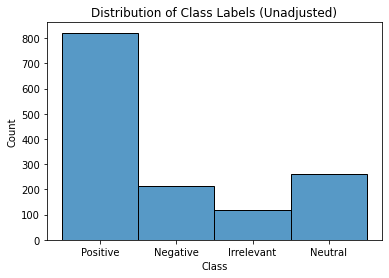

In [ ]:
sns.histplot(df_test_cleaned['Class']).set_title('Distribution of Class Labels (Unadjusted)');

In [ ]:
max_size_oversampling = df_train_cleaned['Class'].value_counts().max()

lst = [df_train_cleaned]

for class_index, group in df_train_cleaned.groupby('Class'):
    lst.append(group.sample(max_size_oversampling-len(group), replace=True))

df_train_oversampled = pd.concat(lst)

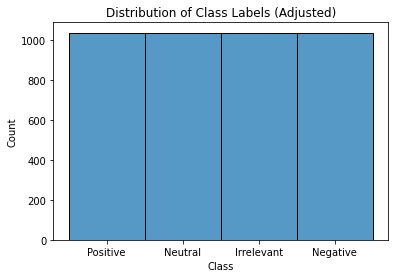

In [ ]:
sns.histplot(df_train_oversampled['Class']).set_title('Distribution of Class Labels (Adjusted)');

In [ ]:
X = df_train_oversampled['Cleaned_Content']

#One hot encode the class variable into an array
unique_tags = list(df_train_oversampled['Class'].unique())
label2idx = {j:i for i,j in enumerate(unique_tags)}
idx2label = {j:i for i,j in label2idx.items()}
print(label2idx)

y = df_train_oversampled['Class'].replace(label2idx).values

{'Positive': 0, 'Neutral': 1, 'Irrelevant': 2, 'Negative': 3}


In [ ]:
X_train, X_validation, y_train, y_validation = train_test_split(X, y, random_state=712, test_size=0.4)

In [ ]:
print(torch.cuda.memory_summary(device=None, abbreviated=False))

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |       0 B  |       0 B  |       0 B  |       0 B  |
|       from large pool |       0 B  |       0 B  |       0 B  |       0 B  |
|       from small pool |       0 B  |       0 B  |       0 B  |       0 B  |
|---------------------------------------------------------------------------|
| Active memory         |       0 B  |       0 B  |       0 B  |       0 B  |
|       from large pool |       0 B  |       0 B  |       0 B  |

In [ ]:
#https://github.com/digitalepidemiologylab/covid-twitter-bert
model_name_ctb_v2 = 'digitalepidemiologylab/covid-twitter-bert-v2'
config_ctb_v2 = AutoConfig.from_pretrained(model_name_ctb_v2, num_labels=4)

#https://github.com/VinAIResearch/BERTweet
model_name_bcb_u = 'vinai/bertweet-covid19-base-uncased'
config_bcb_u = AutoConfig.from_pretrained(model_name_bcb_u, num_labels=4)

model_name_vct = 'ans/vaccinating-covid-tweets'
config_vct = AutoConfig.from_pretrained(model_name_vct, num_labels=4)

model_name_msc = 'clampert/multilingual-sentiment-covid19'
config_msc = config_vct = AutoConfig.from_pretrained(model_name_msc, num_labels=4)


#Initialize Model
model_ctb_v2 = BertForSequenceClassification.from_pretrained(model_name_ctb_v2, num_labels = 4, output_attentions = False,
     output_hidden_states = False)

model_bcb_u = BertForSequenceClassification.from_pretrained(model_name_bcb_u, num_labels = 4, output_attentions = False,
     output_hidden_states = False)

model_vct = BertForSequenceClassification.from_pretrained(model_name_vct, num_labels = 4, output_attentions = False,
    output_hidden_states = False)

model_msc = BertForSequenceClassification.from_pretrained(model_name_msc, num_labels = 4, output_attentions = False,
     output_hidden_states = False)


# Initialize Tokenizer
tokenizer_ctb_v2 = AutoTokenizer.from_pretrained(model_name_ctb_v2)

tokenizer_bcb_u = AutoTokenizer.from_pretrained(model_name_bcb_u)

tokenizer_vct = AutoTokenizer.from_pretrained(model_name_vct)

tokenizer_msc = AutoTokenizer.from_pretrained(model_name_msc)

Some weights of the model checkpoint at digitalepidemiologylab/covid-twitter-bert-v2 were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClass

In [ ]:
def tokenize_tweets(dict_in, data_in):
    for i, val in enumerate(tokenizers):
        tokens_embedded = val.batch_encode_plus(data_in.to_list(), max_length = max_length, return_attention_mask=True,
                                       padding='max_length', truncation=True, return_token_type_ids=False, return_tensors='pt')
        dict_in[i] = tokens_embedded

In [ ]:
tokenizers = [tokenizer_ctb_v2, tokenizer_bcb_u, tokenizer_vct, tokenizer_msc]

In [ ]:
model_suffixes = ['ctb_v2', 'bcb_u', 'vct', 'msc']

In [ ]:
model_list = [model_ctb_v2, model_bcb_u, model_vct, model_msc]

In [ ]:
 for i in model_list:
   print(summary(i))
   print('\n\n')

In [ ]:
first_parameter = next(model_bcb_u.parameters())
input_shape = first_parameter.size()
print(input_shape)

torch.Size([64001, 768])


In [ ]:

model_ctb_v2.load_state_dict(torch.load('/content/gdrive/My Drive/LHS 712/Models/Iteration_2/checkpoint_2_ctb_v2_4.model'))
print(summary(model_ctb_v2))
print('\n\n')
# model_bcb_u.load_state_dict(torch.load('/content/gdrive/My Drive/LHS 712/Models/Iteration_2/checkpoint_2_bcb_u_4.model'))
# model_vct.load_state_dict(torch.load('/content/gdrive/My Drive/LHS 712/Models/Iteration_2/checkpoint_2_vct_4.model'))
# model_msc.load_state_dict(torch.load('/content/gdrive/My Drive/LHS 712/Models/Iteration_2/checkpoint_2_msc_4.model'))

# for i in model_list:
#    print(summary(i))
#    print('\n\n')

In [ ]:
def model_pipeline(model, model_suffix_in, tokenizer_in):
    model.to(device)

    tokens_embedded_train = tokenizer_in.batch_encode_plus(X_train.to_list(), max_length = max_length, return_attention_mask=True,
                                       padding='max_length', truncation=True, return_token_type_ids=False, return_tensors='pt')

    tokens_embedded_valid = tokenizer_in.batch_encode_plus(X_validation.to_list(), max_length = max_length, return_attention_mask=True,
                                       padding='max_length', truncation=True, return_token_type_ids=False, return_tensors='pt')

    train_seq = tokens_embedded_train['input_ids'].to(device)
    train_mask = tokens_embedded_train['attention_mask'].to(device)
    train_y = torch.tensor(y_train).to(device)
    tensor_train = TensorDataset(train_seq, train_mask, train_y)

    val_seq = tokens_embedded_valid['input_ids'].to(device)
    val_mask = tokens_embedded_valid['attention_mask'].to(device)
    val_y = torch.tensor(y_validation).to(device)
    tensor_valid = TensorDataset(val_seq, val_mask, val_y)

    batch_size = 2

    # dataLoader for train set
    train_dataloader = DataLoader(tensor_train,
                                  sampler=RandomSampler(tensor_train),
                                  batch_size=batch_size)

    # dataLoader for validation set
    val_dataloader = DataLoader(tensor_valid,
                                sampler = SequentialSampler(tensor_valid),
                                batch_size=batch_size)

    optimizer = AdamW(model.parameters(), lr = 1e-5, eps = 1e-8)

    epochs = 3

    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0,
                                                num_training_steps=len(train_dataloader)*epochs)
    dictionary = {}

    dictionary[model_suffix_in] = {'train_dataloader': train_dataloader, 'val_dataloader': val_dataloader,
                                   'optimizer': optimizer, 'scheduler': scheduler}
    return dictionary

In [ ]:
def compute_metrics(p):

    pred, labels = p
    pred = np.argmax(pred, axis=1)

    accuracy = accuracy_score(y_true=labels, y_pred=pred)
    recall = recall_score(y_true=labels, y_pred=pred)
    precision = precision_score(y_true=labels, y_pred=pred)
    f1 = f1_score(y_true=labels, y_pred=pred)

    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

In [ ]:
label2idx

{'Irrelevant': 2, 'Negative': 3, 'Neutral': 1, 'Positive': 0}

In [ ]:
def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

def accuracy_per_class(preds, labels):
  label_dict_inverse = {v: k for k, v in label2idx.items()}

  preds_flat = np.argmax(preds, axis=1).flatten()
  labels_flat = labels.flatten()

  # data = {'y_Actual': labels_flat,
  #         'y_Predicted': preds_flat}

  # df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
  # confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'], margins = True)

  # confusion_matrix(y_true, y_pred, labels=["ant", "bird", "cat"])
  plt.figure(figsize=(15,10))

  ConfusionMatrixDisplay.from_predictions(labels_flat, preds_flat, display_labels=['Positive', 'Neutral', 'Negative', 'Irrelevant'])
  plt.show()
  # sns.heatmap(confusion_matrix, annot=True)
  # plt.show()

  for label in np.unique(labels_flat):
      y_preds = preds_flat[labels_flat==label]
      y_true = labels_flat[labels_flat==label]
      print(f'Class: {label_dict_inverse[label]}')
      print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')

In [ ]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

epochs = 4

def evaluate(dataloader_val, model):

    model.eval()

    loss_val_total = 0
    predictions, true_vals = [], []

    for batch in dataloader_val:

        batch = tuple(b for b in batch)

        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():
            outputs = model(**inputs)

        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)

    loss_val_avg = loss_val_total/len(dataloader_val)

    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)

    return loss_val_avg, predictions, true_vals

for i, val in enumerate(model_list):

  model_suffix = model_suffixes[i]
  tokenizer_model = tokenizers[i]

  model_dict = model_pipeline(val, model_suffix, tokenizer_model)

  train_dataloader = model_dict[model_suffix]['train_dataloader']
  val_dataloader = model_dict[model_suffix]['val_dataloader']
  optimizer = model_dict[model_suffix]['optimizer']
  scheduler = model_dict[model_suffix]['scheduler']

  for epoch in tqdm(range(1, epochs+1)):

      val.train()

      loss_train_total = 0

      progress_bar = tqdm(train_dataloader,
                          desc='Epoch {:1d}'.format(epoch),
                          leave=False, disable=False)

      for batch in progress_bar:

          val.zero_grad()

          batch = tuple(b.to(device) for b in batch)

          inputs = {'input_ids':      batch[0],
                    'attention_mask': batch[1],
                    'labels':         batch[2],
                    }

          outputs = val(**inputs)

          loss = outputs[0]
          loss_train_total += loss.item()
          loss.backward()

          torch.nn.utils.clip_grad_norm_(val.parameters(), 1.0)

          optimizer.step()
          scheduler.step()

          progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})


      torch.save(val.state_dict(), f'/content/gdrive/My Drive/LHS 712/Models/Iteration_2/checkpoint_2_{model_suffix}_{epoch}.model')

      tqdm.write(f'\nEpoch {epoch}')

      loss_train_avg = loss_train_total/len(train_dataloader)
      tqdm.write(f'Training loss: {loss_train_avg}')

      val_loss, predictions, true_vals = evaluate(val_dataloader, val)
      val_f1 = f1_score_func(predictions, true_vals)
      tqdm.write(f'Validation loss: {val_loss}')
      tqdm.write(f'F1 Score (Weighted): {val_f1}')

  torch.cuda.empty_cache()

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/1244 [00:00<?, ?it/s]


Epoch 1
Training loss: 1.2068987807312868
Validation loss: 0.8661236545272979
F1 Score (Weighted): 0.6749294016373835


Epoch 2:   0%|          | 0/1244 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.6848406192919215
Validation loss: 0.9042487712192675
F1 Score (Weighted): 0.7783553592233552


Epoch 3:   0%|          | 0/1244 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.40909814580546827
Validation loss: 0.9076878849878776
F1 Score (Weighted): 0.8182864472788364


Epoch 4:   0%|          | 0/1244 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.2924124843634102
Validation loss: 0.9076878849878776
F1 Score (Weighted): 0.8182864472788364


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/1244 [00:00<?, ?it/s]


Epoch 1
Training loss: 1.4345432018016695
Validation loss: 1.3905747924942569
F1 Score (Weighted): 0.18122269132971858


Epoch 2:   0%|          | 0/1244 [00:00<?, ?it/s]


Epoch 2
Training loss: 1.37696279087059
Validation loss: 1.2792965532426375
F1 Score (Weighted): 0.38035904252345715


Epoch 3:   0%|          | 0/1244 [00:00<?, ?it/s]


Epoch 3
Training loss: 1.0958361838887358
Validation loss: 1.1301730872681701
F1 Score (Weighted): 0.5301820575028175


Epoch 4:   0%|          | 0/1244 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.942250738076123
Validation loss: 1.1301730872681701
F1 Score (Weighted): 0.5301820575028175


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/1244 [00:00<?, ?it/s]


Epoch 1
Training loss: 1.4325786109330954
Validation loss: 1.404990432348596
F1 Score (Weighted): 0.10658903556810975


Epoch 2:   0%|          | 0/1244 [00:00<?, ?it/s]


Epoch 2
Training loss: 1.3772273916523556
Validation loss: 1.4053858539426183
F1 Score (Weighted): 0.31533231928155453


Epoch 3:   0%|          | 0/1244 [00:00<?, ?it/s]


Epoch 3
Training loss: 1.0047510381177116
Validation loss: 1.042405212989234
F1 Score (Weighted): 0.5963077484222487


Epoch 4:   0%|          | 0/1244 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.8105755142352493
Validation loss: 1.042405212989234
F1 Score (Weighted): 0.5963077484222487


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/1244 [00:00<?, ?it/s]


Epoch 1
Training loss: 1.434625391599833
Validation loss: 1.383396423581135
F1 Score (Weighted): 0.12798300439744056


Epoch 2:   0%|          | 0/1244 [00:00<?, ?it/s]


Epoch 2
Training loss: 1.3652201054851343
Validation loss: 1.2690449356673712
F1 Score (Weighted): 0.37470798407194605


Epoch 3:   0%|          | 0/1244 [00:00<?, ?it/s]


Epoch 3
Training loss: 1.0818681551167484
Validation loss: 1.1233256957886448
F1 Score (Weighted): 0.5268026985909215


Epoch 4:   0%|          | 0/1244 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.9514888478922163
Validation loss: 1.1233256957886448
F1 Score (Weighted): 0.5268026985909215


In [ ]:
tokenizers = [tokenizer_ctb_v2, tokenizer_bcb_u, tokenizer_vct, tokenizer_msc]
model_list = [model_ctb_v2, model_bcb_u, model_vct, model_msc]
model_suffixes = ['ctb_v2', 'bcb_u', 'vct', 'msc']

In [ ]:
def evaluate(dataloader_val, model):

    model.eval()

    loss_val_total = 0
    predictions, true_vals = [], []

    for batch in dataloader_val:

        batch = tuple(b for b in batch)

        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():
            outputs = model(**inputs)

        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)

    loss_val_avg = loss_val_total/len(dataloader_val)

    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)

    return loss_val_avg, predictions, true_vals

In [ ]:
preds_labels_dict_train = {}
for i,val in enumerate(model_list):
  path = r'/content/gdrive/My Drive/LHS 712/Models/Iteration_2/checkpoint_2_' + model_suffixes[i] + '_4.model'

  val.load_state_dict(torch.load(path, map_location=torch.device('cpu')))

  model_dict = model_pipeline(val, model_suffixes[i], tokenizers[i])

  model_suffix = model_suffixes[i]

  train_dataloader = model_dict[model_suffix]['train_dataloader']
  val_dataloader = model_dict[model_suffix]['val_dataloader']
  optimizer = model_dict[model_suffix]['optimizer']
  scheduler = model_dict[model_suffix]['scheduler']

  _, predictions, true_vals = evaluate(val_dataloader, val)

  preds_labels_dict_train[model_suffix] = {'predictions': predictions, 'true_vals': true_vals}

In [ ]:
preds_labels_dict_valid = {}
for i,val in enumerate(model_list):
  path = r'/content/gdrive/My Drive/LHS 712/Models/Iteration_2/checkpoint_2_' + model_suffixes[i] + '_4.model'

  val.load_state_dict(torch.load(path, map_location=torch.device('cpu')))

  model_dict = model_pipeline(val, model_suffixes[i], tokenizers[i])

  model_suffix = model_suffixes[i]

  train_dataloader = model_dict[model_suffix]['train_dataloader']
  val_dataloader = model_dict[model_suffix]['val_dataloader']
  optimizer = model_dict[model_suffix]['optimizer']
  scheduler = model_dict[model_suffix]['scheduler']

  _, predictions, true_vals = evaluate(val_dataloader, val)

  preds_labels_dict_valid[model_suffix] = {'predictions': predictions, 'true_vals': true_vals}
  #accuracy_per_class(predictions, true_vals)

In [ ]:
df_test_cleaned

y_test = df_test_cleaned['Class'].replace(label2idx).values

def model_pipeline_test(model, model_suffix_in, tokenizer_in):
    model.to(device)

    tokens_embedded_test = tokenizer_in.batch_encode_plus(df_test_cleaned['Cleaned_Content'].to_list(), max_length = max_length, return_attention_mask=True,
                                       padding='max_length', truncation=True, return_token_type_ids=False, return_tensors='pt')

    test_seq = tokens_embedded_test['input_ids'].to(device)
    test_mask = tokens_embedded_test['attention_mask'].to(device)
    test_y = torch.tensor(y_test).to(device)
    tensor_test = TensorDataset(test_seq, test_mask, test_y)

    batch_size = 2

    # dataLoader for train set
    test_dataloader = DataLoader(tensor_test,
                                  sampler=SequentialSampler(tensor_test),
                                  batch_size=batch_size)

    optimizer = AdamW(model.parameters(), lr = 1e-5, eps = 1e-8)

    epochs = 3

    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0,
                                                num_training_steps=len(test_dataloader)*epochs)
    dictionary = {}

    dictionary[model_suffix_in] = {'test_dataloader': test_dataloader, 'optimizer': optimizer, 'scheduler': scheduler}

    return dictionary

preds_labels_dict_test = {}

for i,val in enumerate(model_list):
  path = r'/content/gdrive/My Drive/LHS 712/Models/Iteration_2/checkpoint_2_' + model_suffixes[i] + '_4.model'

  val.load_state_dict(torch.load(path, map_location=torch.device('cpu')))

  model_dict = model_pipeline_test(val, model_suffixes[i], tokenizers[i])

  model_suffix = model_suffixes[i]

  test_dataloader = model_dict[model_suffix]['test_dataloader']
  optimizer = model_dict[model_suffix]['optimizer']
  scheduler = model_dict[model_suffix]['scheduler']

  _, predictions, true_vals = evaluate(test_dataloader, val)

  preds_labels_dict_test[model_suffix] = {'predictions': predictions, 'true_vals': true_vals}
  #accuracy_per_class(predictions, true_vals)

In [ ]:
preds_labels_dict_test

{'bcb_u': {'predictions': array([[ 0.8906585 ,  1.2961688 , -2.6653862 , -0.68712974],
         [ 1.1262472 ,  0.6241941 , -2.795751  , -0.30693474],
         [ 0.6915006 ,  1.4082416 , -2.8847055 , -0.49973327],
         ...,
         [ 1.0579165 ,  0.64892083, -2.590471  , -0.34887636],
         [ 0.902029  ,  0.04718766, -2.212416  ,  0.07475318],
         [ 0.7517538 ,  0.51036376, -2.6068418 ,  0.06774907]],
        dtype=float32), 'true_vals': array([0, 0, 3, ..., 0, 0, 0])},
 'ctb_v2': {'predictions': array([[ 2.0189757 ,  0.82308674, -0.8881721 , -1.8494831 ],
         [ 7.14371   , -2.0637858 , -1.8885561 , -2.1459112 ],
         [ 1.5975871 ,  5.45271   , -2.805587  , -1.6992204 ],
         ...,
         [ 4.599709  , -1.7302113 , -0.96104354, -2.9220643 ],
         [ 6.3090615 , -1.2920873 , -1.721681  , -1.7652801 ],
         [ 5.6802025 , -1.4369636 , -1.3813789 , -2.998209  ]],
        dtype=float32), 'true_vals': array([0, 0, 3, ..., 0, 0, 0])},
 'msc': {'predictions': a

In [ ]:
def accuracy_per_class(preds, labels, model_suffix_in):
  label_dict_inverse = {v: k for k, v in label2idx.items()}
  model_name_in = 'Model_' + model_suffix_in

  preds_flat = np.argmax(preds, axis=1).flatten()
  labels_flat = labels.flatten()



  cmd = ConfusionMatrixDisplay.from_predictions(labels_flat, preds_flat, display_labels=['Positive', 'Neutral', 'Negative', 'Irrelevant'])

  fig, ax = plt.subplots(figsize=(10,10))
  fig.suptitle(f' Confusion Matrix for {model_name_in} (Training Set)', fontsize=20)
  cmd.plot(ax=ax)

  # fig.(figsize=(15,10))
  # plt.title(label=f' Confusion Matrix for {model_name_in} (Training Set)', fontsize=20)

  # plt.show();

  for label in np.unique(labels_flat):
      y_preds = preds_flat[labels_flat==label]
      y_true = labels_flat[labels_flat==label]
      print(f'Class: {label_dict_inverse[label]}')

In [ ]:
preds_labels_dict['ctb_v2']['predictions']

array([[ 5.175253  ,  0.76082313, -2.4292576 , -1.4031346 ],
       [-2.286233  ,  7.1238065 , -2.1631196 , -1.1570572 ],
       [-2.6403685 , -1.9241421 ,  4.5093822 , -2.610319  ],
       ...,
       [-2.4297955 , -2.4483464 ,  4.7058654 , -2.9492767 ],
       [-1.94973   , -1.8078382 , -2.6535895 ,  7.3074307 ],
       [ 1.2365623 ,  3.2509341 , -1.6913857 , -2.0008757 ]],
      dtype=float32)

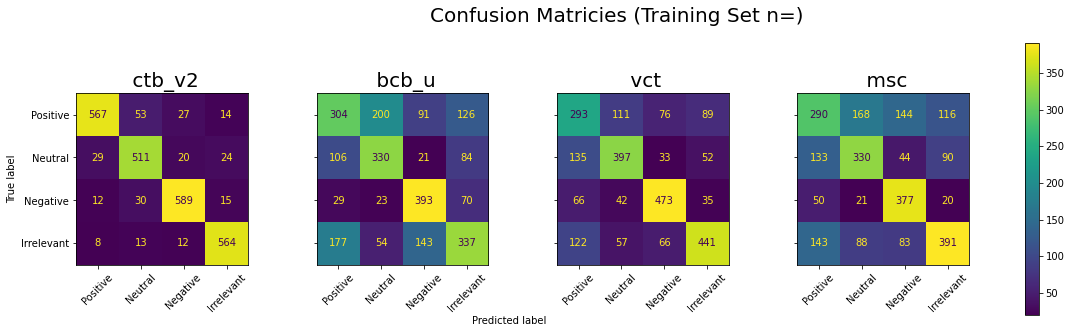

In [ ]:
f, axes = plt.subplots(1, 4, figsize=(20, 5), sharey='row')

for i, (key, classifier) in enumerate(preds_labels_dict.items()):

  preds_flat = np.argmax(classifier['predictions'], axis=1).flatten()
  labels_flat = classifier['true_vals'].flatten()

  model_name_in = 'Model_' + key

  cf_matrix = confusion_matrix(preds_flat, labels_flat)
  disp = ConfusionMatrixDisplay(cf_matrix, display_labels=['Positive', 'Neutral', 'Negative', 'Irrelevant'])
  disp.plot(ax=axes[i], xticks_rotation=45)
  disp.ax_.set_title(f' {key}', fontsize=20)
  disp.im_.colorbar.remove()
  disp.ax_.set_xlabel('')

  if i!=0:
    disp.ax_.set_ylabel('')

f.text(0.4, 0.1, 'Predicted label', ha='left')
plt.subplots_adjust(wspace=0.40, hspace=0.1)

f.colorbar(disp.im_, ax = axes)
f.suptitle('Confusion Matricies (Training Set n=)', fontsize=20)
plt.show()

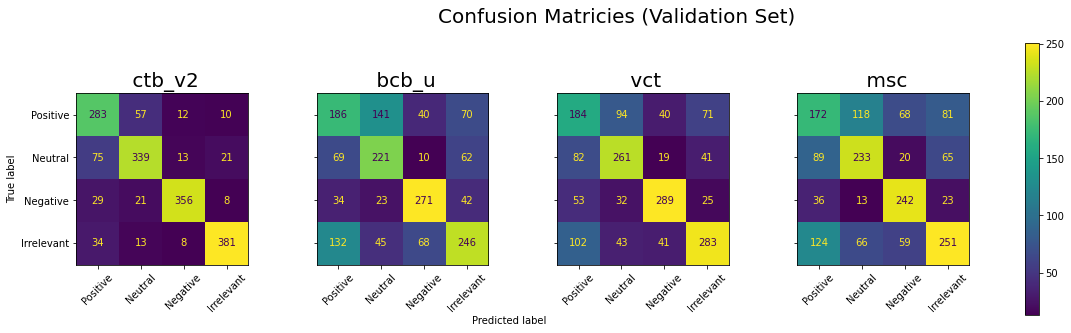

In [ ]:
f, axes = plt.subplots(1, 4, figsize=(20, 5), sharey='row')

for i, (key, classifier) in enumerate(preds_labels_dict_2.items()):

  preds_flat = np.argmax(classifier['predictions'], axis=1).flatten()
  labels_flat = classifier['true_vals'].flatten()

  model_name_in = 'Model_' + key

  cf_matrix = confusion_matrix(preds_flat, labels_flat)
  disp = ConfusionMatrixDisplay(cf_matrix, display_labels=['Positive', 'Neutral', 'Negative', 'Irrelevant'])
  disp.plot(ax=axes[i], xticks_rotation=45)
  disp.ax_.set_title(f' {key}', fontsize=20)
  disp.im_.colorbar.remove()
  disp.ax_.set_xlabel('')

  if i!=0:
    disp.ax_.set_ylabel('')

f.text(0.4, 0.1, 'Predicted label', ha='left')
plt.subplots_adjust(wspace=0.40, hspace=0.1)

f.colorbar(disp.im_, ax = axes)
f.suptitle('Confusion Matricies (Validation Set)', fontsize=20)
plt.show()

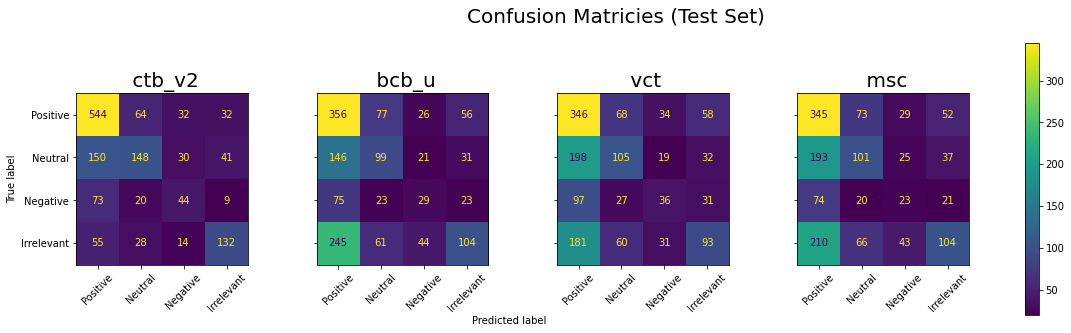

In [ ]:
f, axes = plt.subplots(1, 4, figsize=(20, 5), sharey='row')

for i, (key, classifier) in enumerate(preds_labels_dict_test.items()):

  preds_flat = np.argmax(classifier['predictions'], axis=1).flatten()
  labels_flat = classifier['true_vals'].flatten()

  model_name_in = 'Model_' + key

  cf_matrix = confusion_matrix(preds_flat, labels_flat)
  disp = ConfusionMatrixDisplay(cf_matrix, display_labels=['Positive', 'Neutral', 'Negative', 'Irrelevant'])
  disp.plot(ax=axes[i], xticks_rotation=45)
  disp.ax_.set_title(f' {key}', fontsize=20)
  disp.im_.colorbar.remove()
  disp.ax_.set_xlabel('')

  if i!=0:
    disp.ax_.set_ylabel('')

f.text(0.4, 0.1, 'Predicted label', ha='left')
plt.subplots_adjust(wspace=0.40, hspace=0.1)

f.colorbar(disp.im_, ax = axes)
f.suptitle('Confusion Matricies (Test Set)', fontsize=20)
plt.show()

In [ ]:
for i, (key, classifier) in enumerate(preds_labels_dict_test.items()):
  preds_flat = np.argmax(classifier['predictions'], axis=1).flatten()
  print(preds_flat)
  labels_flat = classifier['true_vals'].flatten()
  model_name_in = 'Model_' + key

  PrecisionRecallDisplay.from_predictions(labels_flat,
                                          preds_flat)
  plt.show()

[0 0 1 ... 0 0 0]


ValueError: ignored

### Prediction on entire dataset

In [ ]:
!gdown --id "19B6t-NrYOP2HWPzQIS-IXoXQD1lQFY7L"

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=19B6t-NrYOP2HWPzQIS-IXoXQD1lQFY7L
To: /content/tweet_output_cleaned.csv
100% 38.6M/38.6M [00:00<00:00, 47.8MB/s]


In [ ]:
df_predict = pd.read_csv(r'/content/tweet_output_cleaned.csv', encoding= 'unicode_escape')

In [ ]:
df_predict = clean_text(df_predict)
df_predict_cleaned = df_predict[['Cleaned_Content', 'Hashtags', 'Phrase']]

In [ ]:
X_predict = list(df_predict_cleaned['Cleaned_Content'])

In [ ]:
tokens_embedded_predict = tokenizer_ctb_v2.batch_encode_plus(X_predict, max_length = max_length, return_attention_mask=True,
                                    padding='max_length', truncation=True, return_token_type_ids=False, return_tensors='pt')

predict_seq = tokens_embedded_predict['input_ids'].to(device)
predict_mask = tokens_embedded_predict['attention_mask'].to(device)
tensor_predict = TensorDataset(predict_seq, predict_mask)

# dataLoader for prediction set
predict_dataloader = DataLoader(tensor_predict,
                              sampler=SequentialSampler(tensor_predict),
                              batch_size=2)

In [ ]:
len(predict_dataloader)

61511

In [ ]:
model_ctb_v2.load_state_dict(torch.load('/content/gdrive/My Drive/LHS 712/Models/Iteration_2/checkpoint_2_ctb_v2_4.model', map_location=torch.device('cpu')))


def evaluate_predict(dataloader_val, model):

  model.eval()

  sum_total = 0

  loss_val_total = 0
  predictions = []

  for batch in dataloader_val:

      batch = tuple(b.to(device) for b in batch)

      inputs = {'input_ids':      batch[0],
                'attention_mask': batch[1],
                }

      with torch.no_grad():
          outputs = model(**inputs)

      logits = outputs[0]

      logits = logits.detach().cpu().numpy()
      predictions.append(logits)

      sum_total += 1
      print(sum_total/len(dataloader_val))

  predictions = np.concatenate(predictions, axis=0)

  return predictions

sentiment_predictions = evaluate_predict(predict_dataloader, model_ctb_v2)

Streaming output truncated to the last 5000 lines.
0.9187299832550275
0.9187462405098276
0.9187624977646275
0.9187787550194274
0.9187950122742273
0.9188112695290274
0.9188275267838273
0.9188437840386272
0.9188600412934272
0.9188762985482272
0.9188925558030271
0.918908813057827
0.918925070312627
0.918941327567427
0.9189575848222269
0.9189738420770269
0.9189900993318268
0.9190063565866268
0.9190226138414267
0.9190388710962267
0.9190551283510267
0.9190713856058266
0.9190876428606266
0.9191039001154265
0.9191201573702265
0.9191364146250264
0.9191526718798264
0.9191689291346263
0.9191851863894263
0.9192014436442263
0.9192177008990262
0.9192339581538261
0.9192502154086261
0.9192664726634261
0.919282729918226
0.9192989871730259
0.919315244427826
0.9193315016826259
0.9193477589374258
0.9193640161922257
0.9193802734470258
0.9193965307018257
0.9194127879566256
0.9194290452114255
0.9194453024662256
0.9194615597210255
0.9194778169758254
0.9194940742306255
0.9195103314854254
0.9195265887402253
0.91

In [ ]:
display(sentiment_predictions)
display(np.argmax(sentiment_predictions, axis=1))

array([[-0.8212101 ,  3.0368717 , -0.5923665 , -1.9483311 ],
       [-0.44244596,  6.478236  , -2.2176158 , -2.058567  ],
       [-0.04790341, -2.7792025 ,  3.6756318 , -3.0021615 ],
       ...,
       [-1.411074  , -2.0414367 , -2.2813385 ,  6.310652  ],
       [ 3.6742022 , -2.3014188 , -2.572489  ,  3.003778  ],
       [-0.93607295,  4.9845514 , -0.9642613 , -2.3635824 ]],
      dtype=float32)

array([1, 1, 2, ..., 3, 0, 1])

In [ ]:
y_predicted = np.argmax(sentiment_predictions, axis=1)
y_predicted = [idx2label[i] for i in y_predicted]

In [ ]:
y_predicted

['Neutral',
 'Neutral',
 'Irrelevant',
 'Irrelevant',
 'Neutral',
 'Neutral',
 'Positive',
 'Positive',
 'Positive',
 'Positive',
 'Irrelevant',
 'Irrelevant',
 'Irrelevant',
 'Irrelevant',
 'Positive',
 'Irrelevant',
 'Positive',
 'Negative',
 'Irrelevant',
 'Irrelevant',
 'Neutral',
 'Neutral',
 'Negative',
 'Neutral',
 'Positive',
 'Positive',
 'Positive',
 'Neutral',
 'Neutral',
 'Neutral',
 'Positive',
 'Irrelevant',
 'Positive',
 'Irrelevant',
 'Irrelevant',
 'Irrelevant',
 'Positive',
 'Irrelevant',
 'Irrelevant',
 'Positive',
 'Irrelevant',
 'Irrelevant',
 'Neutral',
 'Neutral',
 'Neutral',
 'Irrelevant',
 'Irrelevant',
 'Irrelevant',
 'Positive',
 'Positive',
 'Positive',
 'Positive',
 'Negative',
 'Neutral',
 'Irrelevant',
 'Positive',
 'Positive',
 'Negative',
 'Neutral',
 'Irrelevant',
 'Irrelevant',
 'Irrelevant',
 'Irrelevant',
 'Positive',
 'Positive',
 'Irrelevant',
 'Irrelevant',
 'Irrelevant',
 'Irrelevant',
 'Negative',
 'Positive',
 'Neutral',
 'Irrelevant',
 'Irrel

In [ ]:
#df_out = pd.read_csv(r'/content/tweet_output_cleaned.csv', encoding= 'unicode_escape')

df_out['Labels_2'] = y_predicted

In [ ]:
df_predict_cleaned['Labels'] = y_predicted
df_predict_cleaned.head(n=50)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Cleaned_Content,Hashtags,Phrase,Labels
0,Of course Anything else would be gop er I me...,"#COVID, #CovidVaccine",COVID19Vaccine,Neutral
1,COVID Vaccine Shipped and Drug Trials Start #c...,#covidvaccine,COVID19Vaccine,Neutral
2,Survey data from show #HPV #vaccination rates...,"#HPV, #vaccination, #GetVaccinated, #PreventHPV",GetVaccinated,Irrelevant
3,Hey whats in the box lady Getting my second s...,"#provaxxer, #provax, #getvaccinated, #shingles...",GetVaccinated,Irrelevant
4,Worthless comparison People get vaccinated aga...,,COVIDVaccine,Neutral
5,People like him are the ones the new Covid va...,,COVIDVaccine,Neutral
6,If they get a #COVID vaccine how many antivaxx...,#COVID,COVIDVaccine,Positive
7,Even if Chinas actual case numbers are x hi...,,COVIDVaccine,Positive
8,NVAX Phase trial results for their #NanoFlu...,"#NanoFlu, #COVID, #vaccine, #NanoFlu, #vaccine...",COVIDVaccine,Positive
9,Its first line prevention against influenza o...,,vaccinate,Positive


In [ ]:
from google.colab import files
df_predict_cleaned.to_csv('tweet_output_cleaned_predictions.csv')
files.download('tweet_output_cleaned_predictions.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
df_out['State'] = df_out[df_out['Location'].str.contains('United States')]['Location'].str.extract(r'([\w\s]+),')

In [ ]:
pd.DataFrame(df_out.groupby(by='State')['Labels'].value_counts()).head(n=50)

Labels
State       Labels            
 Maryland   Positive       791
            Neutral        295
            Irrelevant     176
            Negative       132
 Santa Cruz Negative         1
Alabama     Positive       206
            Neutral        108
            Negative        58
            Irrelevant      35
Alaska      Positive        91
            Neutral         34
            Irrelevant      16
            Negative        15
Anaheim     Positive         1
Antioch     Positive         4
Arenal      Negative         1
Arizona     Positive       553
            Neutral        257
            Negative       228
            Irrelevant     123
Arkansas    Positive        56
            Negative        27
            Irrelevant      17
            Neutral         13
Berkeley    Positive        11
            Neutral          3
California  Positive      5616
            Neutral       2877
            Negative      1290
            Irrelevant    1031
Campbell    Neutral          1
            Positive         1
Colorado    Positive       463
            Neutral        220
            Negative       121
            Irrelevant      98
Davis       Negative         1
            Positive         1
Delaware    Positive        53
            Neutral         21
            Negative        14
            Irrelevant       7
East Coast  Negative         1
Florida     Positive      1325
            Neutral        684
            Negative       582
            Irrelevant     324
Georgia     Positive       554
            Neutral        295
            Negative       196

### Prediction on city level data

In [ ]:
!gdown --id "1dfyZOTFDDtjS_oR4vbXQ21W3mn5hkf1s"

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1dfyZOTFDDtjS_oR4vbXQ21W3mn5hkf1s
To: /content/Sf_Detroit_Tweets.xlsx
100% 352k/352k [00:00<00:00, 99.5MB/s]


In [ ]:
df_SF_detroit_predict = pd.read_excel(r'/content/Sf_Detroit_Tweets.xlsx', sheet_name='Sheet1')

/usr/local/lib/python3.7/dist-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [ ]:
df_SF_detroit_predict = clean_text(df_SF_detroit_predict)
df_SF_detroit_predict_cleaned = df_SF_detroit_predict[['Cleaned_Content', 'Hashtags', 'Phrase']]

In [ ]:
X_SF_detroit_predict = list(df_SF_detroit_predict_cleaned['Cleaned_Content'])

In [ ]:
tokens_embedded_predict = tokenizer_ctb_v2.batch_encode_plus(X_SF_detroit_predict, max_length = max_length, return_attention_mask=True,
                                    padding='max_length', truncation=True, return_token_type_ids=False, return_tensors='pt')

predict_seq = tokens_embedded_predict['input_ids'].to(device)
predict_mask = tokens_embedded_predict['attention_mask'].to(device)
tensor_predict = TensorDataset(predict_seq, predict_mask)

# dataLoader for prediction set
predict_dataloader = DataLoader(tensor_predict,
                              sampler=SequentialSampler(tensor_predict),
                              batch_size=16)

In [ ]:
model_ctb_v2.load_state_dict(torch.load('/content/gdrive/My Drive/LHS 712/Models/Iteration_2/checkpoint_2_ctb_v2_4.model', map_location=torch.device('cpu')))


def evaluate_predict(dataloader_val, model):

  model.eval()

  sum_total = 0

  loss_val_total = 0
  predictions = []

  for batch in dataloader_val:

      batch = tuple(b.to(device) for b in batch)

      inputs = {'input_ids':      batch[0],
                'attention_mask': batch[1],
                }

      with torch.no_grad():
          outputs = model(**inputs)

      logits = outputs[0]

      logits = logits.detach().cpu().numpy()
      predictions.append(logits)

      sum_total += 1
      print(sum_total/len(dataloader_val))

  predictions = np.concatenate(predictions, axis=0)

  return predictions

sentiment_predictions = evaluate_predict(predict_dataloader, model_ctb_v2)

RuntimeError: ignored